# Model Performance Metrics

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings(action='ignore') 

import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (12,5)
plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

# 데이터 확보

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


특성행렬(X)의 인스턴스: 500개, 변수: 2 개
종속변수(y)의 고유값 종류: [0 1]


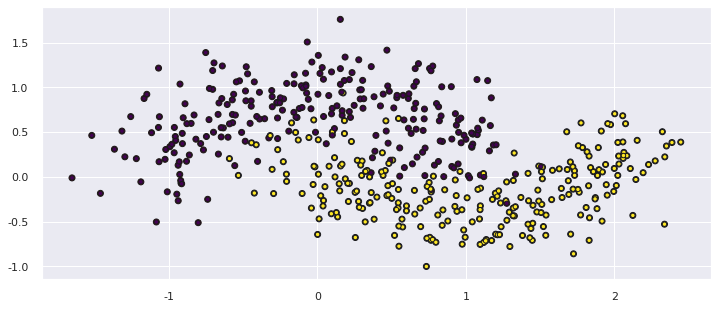

In [5]:
from sklearn.datasets import make_classification, make_moons

X, y = make_classification(n_samples=500, n_classes=2, weights=[0.9, 0.1], random_state=1)
X, y = make_moons(n_samples=500, noise=.25, random_state=1)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', edgecolor='k')
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='viridis', edgecolor='k')
print(f'특성행렬(X)의 인스턴스: {X.shape[0]}개, 변수: {X.shape[1]} 개')
print(f'종속변수(y)의 고유값 종류: {np.unique(y)}')

In [6]:
# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# metrics
from sklearn import metrics

# model selection 
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

# visulalization
!pip install scikit-plot
import scikitplot as skplt

In [7]:
print(f'K-nearest neighbors의 하이퍼파라미터 : {KNeighborsClassifier().get_params()}\n')
print(f'Logistic regression의 하이퍼파라미터 : {LogisticRegression().get_params()}\n')

K-nearest neighbors의 하이퍼파라미터 : {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}

Logistic regression의 하이퍼파라미터 : {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}



In [11]:
classifiers = {}
classifiers.update({'KNN': KNeighborsClassifier()})
classifiers.update({'LGR': LogisticRegression()})

parameters = {}
parameters.update({'KNN' : 
                   {
                       'classifier__n_neighbors' : [ 3, 7, 9, 13, 17, 21],
                       'classifier__p' : [1, 2]}
                  })
parameters.update({'LGR':
                  {
                      'classifier__C': [0.01, 0.1, 10],
                      'classifier__penalty': ['l1', 'l2']}
                  })

In [12]:
classifiers
parameters

{'KNN': KNeighborsClassifier(), 'LGR': LogisticRegression()}

{'KNN': {'classifier__n_neighbors': [3, 7, 9, 13, 17, 21],
  'classifier__p': [1, 2]},
 'LGR': {'classifier__C': [0.01, 0.1, 10],
  'classifier__penalty': ['l1', 'l2']}}

In [13]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, 
                                                  stratify= y, random_state=11)

## 모델 성능지표(performance metrics) 비교

In [23]:
for classifier_label, classifier in classifiers.items():
  classifier_label
  print('\n')
  classifier
  print('\n')
  steps = [('scaler', StandardScaler()), # 자료표준화
             ('classifier', classifier)]
  print(steps)
  print(parameters[classifier_label])
  print('*'*100)

'KNN'

KNeighborsClassifier()



[('scaler', StandardScaler()), ('classifier', KNeighborsClassifier())]
{'classifier__n_neighbors': [3, 7, 9, 13, 17, 21], 'classifier__p': [1, 2]}
****************************************************************************************************


'LGR'

LogisticRegression()



[('scaler', StandardScaler()), ('classifier', LogisticRegression())]
{'classifier__C': [0.01, 0.1, 10], 'classifier__penalty': ['l1', 'l2']}
****************************************************************************************************


In [24]:
from tqdm import tqdm_notebook
from joblib import dump, load

kf = KFold(n_splits=3)
results = {}

for classifier_label, classifier in tqdm_notebook(classifiers.items()):
    
    print(f'알고리즘: {classifier}')
    steps = [('scaler', StandardScaler()), # 자료표준화
             ('classifier', classifier)]
    
    pipeline = Pipeline(steps = steps)
    
    #param_grid = {} # No hyperparameter tuning
    param_grid = parameters[classifier_label]
        
    gs = RandomizedSearchCV(pipeline, param_grid, cv = kf,
                          n_iter = 2,
                          scoring = 'f1_macro') 
    
    y_pred = gs.fit(X_train, y_train).predict(X_test)
    y_proba = gs.predict_proba(X_test)
    y_score = y_proba[:,1]  # P(y=1)
    
    print(f'최적 모델: {gs.best_estimator_} 아래 폴더에 저장....')
    dump(gs.best_estimator_, classifier_label + '.joblib')
    #dump(gs.best_estimator_, '../working/' + classifier_label + '.joblib')
    print('*'*100)
    
    result = {'Best Parameters': gs.best_params_,
              'Training recall_macro': gs.best_score_,
              'Test recall_macro': metrics.recall_score(y_test, y_pred, average='macro'),
              'AUROC': metrics.roc_auc_score(y_test, y_score),
              'Average PR': metrics.average_precision_score(y_test, y_score),
              'F1-score': metrics.f1_score(y_test, y_pred),
              'Log_loss': metrics.log_loss(y_test, y_proba),
              'Brier_score': metrics.brier_score_loss(y_test, y_score),
             }
 
    results.update({classifier_label: result})

  0%|          | 0/2 [00:00<?, ?it/s]

알고리즘: KNeighborsClassifier()
최적 모델: Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_neighbors=21))]) 아래 폴더에 저장....


['KNN.joblib']

****************************************************************************************************
알고리즘: LogisticRegression()
최적 모델: Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression(C=0.01))]) 아래 폴더에 저장....


['LGR.joblib']

****************************************************************************************************


In [25]:
pd.DataFrame(results).T

,Best Parameters,Training recall_macro,Test recall_macro,AUROC,Average PR,F1-score,Log_loss,Brier_score
KNN,"{'classifier__p': 2, 'classifier__n_neighbors'...",0.914815,0.95,0.9906,0.990482,0.950495,0.131385,0.037528
LGR,"{'classifier__penalty': 'l2', 'classifier__C':...",0.85244,0.84,0.9588,0.962465,0.854545,0.432355,0.129595


### **Probability calibration**
When performing classification you often want not only to predict the class label, but also obtain a probability of the respective label. This probability gives you some kind of confidence on the prediction.
- 식약처 위해도 예측모형의 확률구간은 신뢰적이지 못함(Why? 아래 그림 X축의 '0 ~ 0.1'구간에서 위해도 예측확률이나 그 위의 구간이나 실제 부적합(정밀검사)의 비율이 동일

In [26]:
classifier_labels = []
probas_list = []

for classifier_label, classifier in classifiers.items():
    steps = [('classifier', classifier)]
    pipeline = Pipeline(steps = steps)
    param_grid = {}   
    gs = RandomizedSearchCV(pipeline, param_grid, cv = kf,
                          n_iter = 2, scoring = 'f1_micro')  
    y_proba = gs.fit(X_train, y_train).predict_proba(X_test)
    probas_list.append(y_proba)
    classifier_labels.append(classifier_label)

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


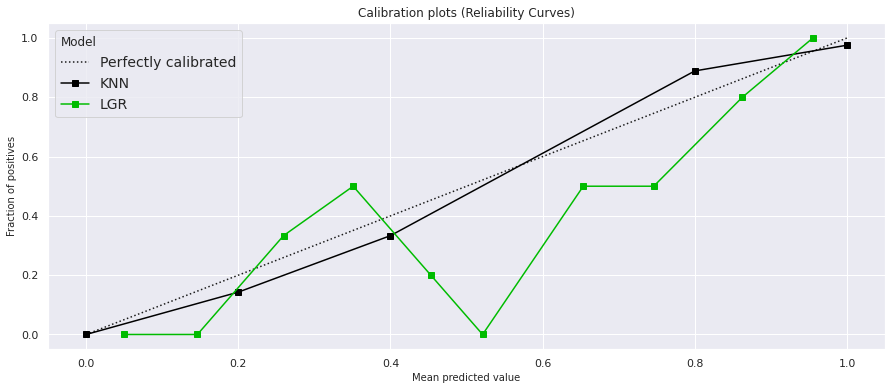

In [27]:
skplt.metrics.plot_calibration_curve(y_test, probas_list, classifier_labels, figsize=(15,6))

leg = plt.legend(title='Model', fontsize = 14)
leg._legend_box.align = 'left'

### Model 불러오기 (이미 학습이 완료)

In [28]:
clf = load('LGR.joblib') 
clf
#clf.fit(X_train, y_train) # 학습과정이 필요없다는 뜻

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression(C=0.01))])

# A. Threshold Metrics
### Confusion matrix

In [29]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)
y_score = y_proba[:,1]  # P(y=1)
y_true = y_test

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

array([[37, 13],
       [ 3, 47]])

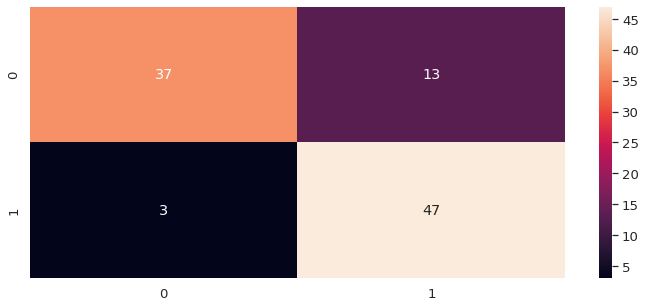

In [31]:
confusion_matrix(y_true, y_pred)
sns.set(font_scale=1.2)
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)

In [32]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.74      0.82        50
           1       0.78      0.94      0.85        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



# B. Ranking Metrics

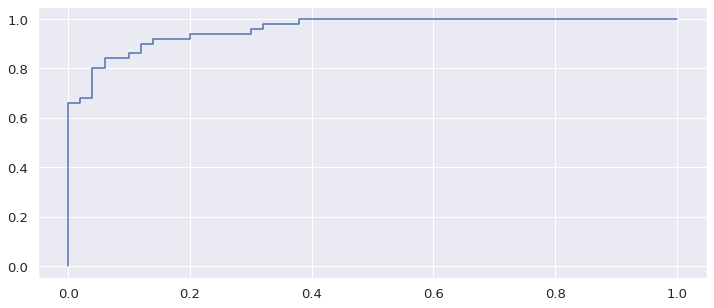

In [33]:
from sklearn import metrics 
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_proba[:, 1])
plt.plot(fpr, tpr)

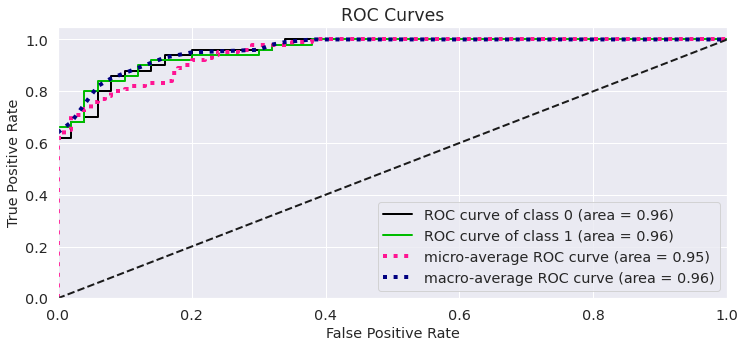

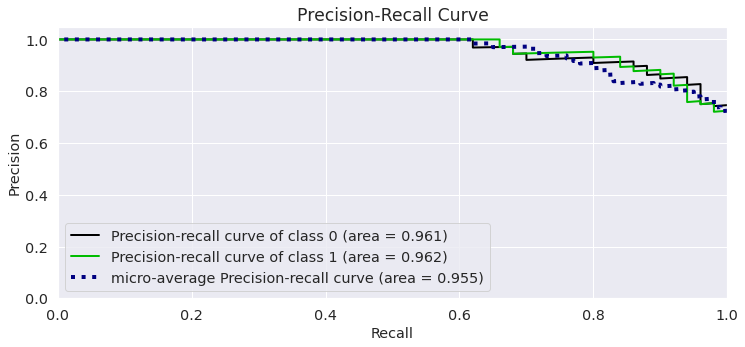

In [34]:
import scikitplot as skplt 
skplt.metrics.plot_roc(y_true, y_proba)
skplt.metrics.plot_precision_recall(y_true, y_proba)

In [35]:
from sklearn.metrics import precision_recall_curve

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba[:, 1])
scores = [np.sum(to_labels(y_proba[:, 1], t))/len(y_proba[:, 1]) for t in thresholds]

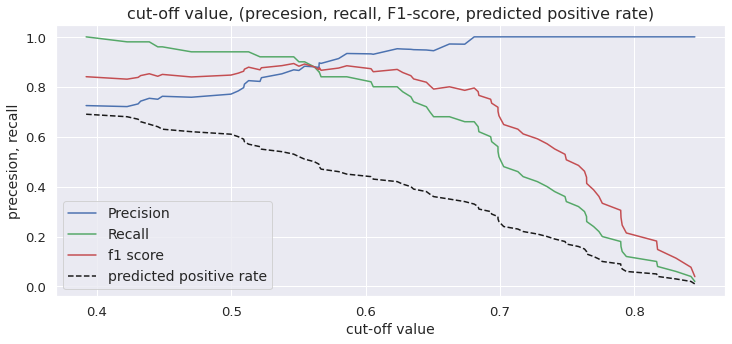

In [36]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.title('cut-off value, (precesion, recall, F1-score, predicted positive rate)', fontsize='16') 
    plt.plot(thresholds, precisions[:-1], 'b-', label='Precision') # 판사
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall') # 검사
    plt.plot(thresholds, (2*precisions[:-1]*recalls[:-1])/(precisions[:-1] +recalls[:-1]), 
             'r-', label='f1 score') # 변호사
    plt.plot(thresholds, scores, 'k--', label='predicted positive rate') # q-ratio
    plt.ylabel('precesion, recall', fontsize='14') 
    plt.xlabel('cut-off value', fontsize='14') 
    plt.legend(loc='best', fontsize='14') 
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

# C Probablistic Metrics

### <font color='blue'> Performance Metrics for Imbalanced 

## Cohen’s kappa
The kappa score (see docstring) is a number between -1 and 1. Scores above .8 are generally considered good agreement; zero or lower means no agreement (practically random labels).

In [37]:
metrics.cohen_kappa_score(y_true, y_pred)

0.6799999999999999

## Balanced_accuracy_score
The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets. It is defined as the average of recall obtained on each class.
The best value is 1 and the worst value is 0 when adjusted=False.

In [38]:
metrics.balanced_accuracy_score(y_true, y_pred)

0.84

## Matthews correlation coefficient
The matthews_corrcoef function computes the Matthew’s correlation coef
“The Matthews correlation coefficient is used in machine learning as a measure of the quality of binary (two-class) classifications. It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction. The statistic is also known as the phi coefficient.”

In [39]:
metrics.matthews_corrcoef(y_true, y_pred)

0.6940220937885672

## f1-score가 최대인 threshold

In [40]:
from sklearn.metrics import f1_score
scores = [f1_score(y_true, to_labels(y_proba[:, 1], t)) for t in thresholds]
ix = np.argmax(scores)
print(f'Threshold(분류임계값)={thresholds[ix]:.3f}, at Maximum F-measure={scores[ix]:.3f}')

Threshold(분류임계값)=0.547, at Maximum F-measure=0.893


## Brier_score

In [41]:
from sklearn.metrics import brier_score_loss
brier_score_loss(y_true, y_proba[:, 1])

0.12959507950536556

## Lift curve, cumulative gain curve

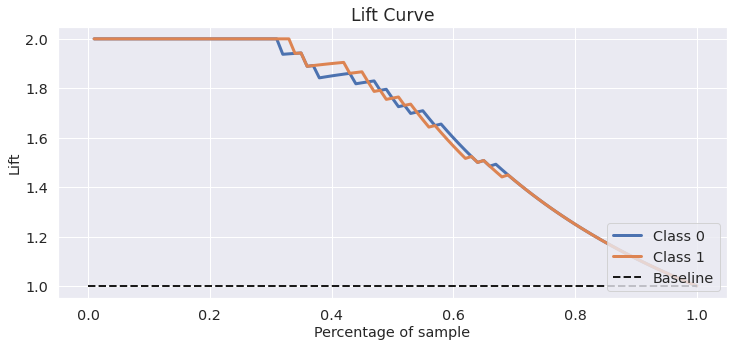

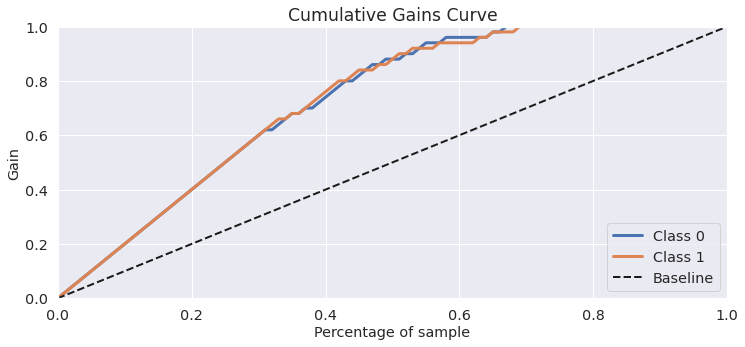

In [42]:
skplt.metrics.plot_lift_curve(y_true, y_proba); plt.show()
skplt.metrics.plot_cumulative_gain(y_true, y_proba)

## Kolmogorov-Smirnov Test

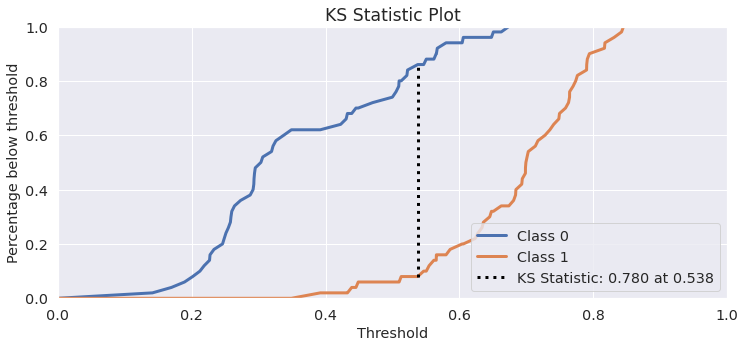

In [43]:
skplt.metrics.plot_ks_statistic(y_true, y_proba)

**The measure of separability, or KS test result would be 75.7% (점선의 길이)**
- Class 0과 Class 1의 확률분포의 차이가 있는가? 같다는 귀무가설을 p-value 만큼 기각, 즉 귀무가설을 기각, 즉 두 분포는 다르다

In [44]:
from scipy.stats import ks_2samp
print(ks_2samp(y_proba[:, 0], y_proba[:, 1]))

Ks_2sampResult(statistic=0.21, pvalue=0.024055802841094577)


### **Probability calibration**
When performing classification you often want not only to predict the class label, but also obtain a probability of the respective label. This probability gives you some kind of confidence on the prediction.
- 식약처 위해도 예측모형의 확률구간은 신뢰적이지 못함(Why? 아래 그림 X축의 '0 ~ 0.1'구간에서 위해도 예측확률이나 그 위의 구간이나 실제 부적합(정밀검사)의 비율이 동일

(array([ 4., 14., 13.,  2.,  6., 12., 10., 16., 13., 10.]),
 array([0.14153846, 0.21188516, 0.28223187, 0.35257857, 0.42292528,
        0.49327198, 0.56361869, 0.63396539, 0.70431209, 0.7746588 ,
        0.8450055 ]),
 <a list of 10 Patch objects>)

(array([10., 13., 16., 10., 12.,  6.,  2., 13., 14.,  4.]),
 array([0.1549945 , 0.2253412 , 0.29568791, 0.36603461, 0.43638131,
        0.50672802, 0.57707472, 0.64742143, 0.71776813, 0.78811484,
        0.85846154]),
 <a list of 10 Patch objects>)

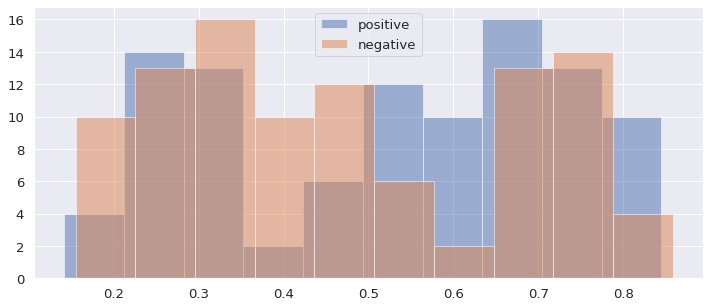

In [45]:
plt.hist(y_proba[:, 1], label='positive', alpha=0.5)
plt.hist(y_proba[:, 0], label='negative', alpha=0.5)
plt.legend()

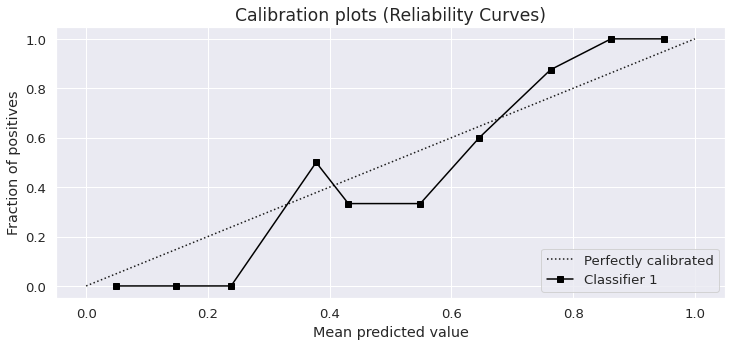

In [46]:
skplt.metrics.plot_calibration_curve(y_true, [y_proba])

In [7]:
data = pd.DataFrame(np.c_[X, y])
data.columns = ['x1', 'x2', 'Target']
data.head()

,x1,x2,Target
0,0.456512,0.071161,1.0
1,0.984704,-0.593088,1.0
2,0.935407,0.578138,0.0
3,0.393591,0.463981,0.0
4,2.144325,-0.029013,1.0


## **Pycaret_classification**

In [1]:
! pip install pycaret
from pycaret.utils import version
version()

     |████████████████████████████████| 319 kB 5.5 MB/s 
     |████████████████████████████████| 2.0 MB 39.3 MB/s 
     |████████████████████████████████| 86 kB 1.8 MB/s 
     |████████████████████████████████| 1.7 MB 31.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 261 kB 46.8 MB/s 
     |████████████████████████████████| 167 kB 48.7 MB/s 
     |████████████████████████████████| 1.3 MB 44.8 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
     |████████████████████████████████| 6.8 MB 36.5 MB/s 
     |████████████████████████████████| 116 kB 51.7 MB/s 
     |████████████████████████████████| 16.5 MB 199 kB/s 
     |████████████████████████████████| 10.9 MB 34.0 MB/s 
     |████████████████████████████████| 636 kB 48.8 MB/s 
     |████████████████████████████████| 102 kB 12.3 MB/s 
     |█████████████████

'2.3.9'

In [2]:
from pycaret.utils import version
version()

'2.3.9'

In [8]:
from pycaret.classification import *
clf1 = setup(data = data, target = 'Target',
             silent = True)

,Description,Value
0,session_id,582
1,Target,Target
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(500, 3)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
best = compare_models(sort = 'recall', fold=2) #default is 'Accuracy'
best

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.8941,0.9657,0.9176,0.8833,0.8996,0.7874,0.7893,0.0350
catboost,CatBoost Classifier,0.9141,0.9747,0.9176,0.9173,0.9174,0.8280,0.8281,0.8000
knn,K Neighbors Classifier,0.9084,0.9631,0.9121,0.9123,0.9122,0.8164,0.8164,1.2850
rf,Random Forest Classifier,0.9141,0.9661,0.9066,0.9277,0.9163,0.8280,0.8296,0.1000
lightgbm,Light Gradient Boosting Machine,0.8969,0.9640,0.9066,0.8966,0.9014,0.7933,0.7936,0.2750
dt,Decision Tree Classifier,0.8855,0.8849,0.8956,0.8858,0.8900,0.7704,0.7718,1.2700
gbc,Gradient Boosting Classifier,0.8997,0.9639,0.8956,0.9117,0.9027,0.7993,0.8009,0.0250
et,Extra Trees Classifier,0.9055,0.9637,0.8956,0.9208,0.9080,0.8109,0.8112,0.0800
xgboost,Extreme Gradient Boosting,0.8969,0.9654,0.8901,0.9101,0.8999,0.7936,0.7940,0.0800
lr,Logistic Regression,0.8453,0.9416,0.8681,0.8410,0.8540,0.6895,0.6906,1.6400


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=6618)

- 상관계수와 유사한 지표인 MCC는 실제와 예측과의 상관관계를 나타낸다. '-1'부터 '1'까지의 값을 가지며
- '1'은 100% 정확한 예측, '0'은 무작위 예측, '-1'은 100% 부정확한 예측을 의미한다.
- 사이킷런은 MCC와 유사한 지표로 cohen_kappa_score도 제공한다.

In [ ]:
knn = create_model('knn', fold = 2)
tunes_knn = tune_model(knn, fold = 2)
tunes_knn

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8971,0.9611,0.8681,0.9294,0.8977,0.7945,0.7964
1,0.9310,0.9844,0.9231,0.9438,0.9333,0.8619,0.8622
Mean,0.9141,0.9728,0.8956,0.9366,0.9155,0.8282,0.8293
SD,0.0169,0.0117,0.0275,0.0072,0.0178,0.0337,0.0329


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
                     weights='uniform')

In [ ]:
predict_model(tunes_knn)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.9338,0.9846,0.9265,0.9265,0.9265,0.8662,0.8662


,x1,x2,Target,Label,Score
0,-0.040913,-0.348173,1.0,1.0,1.0
1,0.658024,1.210395,0.0,0.0,1.0
2,0.972652,-0.366994,1.0,1.0,1.0
3,-0.648158,0.446756,0.0,0.0,0.9
4,1.275662,-0.484798,1.0,1.0,1.0
...,...,...,...,...,...
146,2.063536,0.274146,1.0,1.0,1.0
147,-1.066917,0.169805,0.0,0.0,1.0
148,0.334347,0.072237,1.0,1.0,0.8
149,2.274530,0.179412,1.0,1.0,1.0


- Score means the probability of the predicted class (NOT the positive class). 
- If Label is 0 and Score is 0.90, it means 90% probability of class 0. 
If you want to see the probability of both the classes, simply pass raw_score=True in the predict_model function.

In [ ]:
predictions = predict_model(tunes_knn)
predictions

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.9338,0.9846,0.9265,0.9265,0.9265,0.8662,0.8662


,x1,x2,Target,Label,Score
0,-0.040913,-0.348173,1.0,1.0,1.0
1,0.658024,1.210395,0.0,0.0,1.0
2,0.972652,-0.366994,1.0,1.0,1.0
3,-0.648158,0.446756,0.0,0.0,0.9
4,1.275662,-0.484798,1.0,1.0,1.0
...,...,...,...,...,...
146,2.063536,0.274146,1.0,1.0,1.0
147,-1.066917,0.169805,0.0,0.0,1.0
148,0.334347,0.072237,1.0,1.0,0.8
149,2.274530,0.179412,1.0,1.0,1.0


In [ ]:
evaluate_model(tunes_knn)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

# End